In [1]:
import os
import pickle as pkl
import sys
import matplotlib.pyplot as plt
try:
    os.environ['SESNPATH']
    os.environ['SESNCFAlib']

except KeyError:
    print ("must set environmental variable SESNPATH and SESNCfAlib")
    sys.exit()

cmd_folder = os.getenv("SESNCFAlib")
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)
cmd_folder = os.getenv("SESNCFAlib") + "/templates"
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

from savgol import savitzky_golay
from snclasses import *
from templutils import *
import pandas as pd

In [2]:
SNTYPES = ['Ib','IIb','Ic','Ic-bl', 'Ibn']

bands = ['R','V','r','g','U','u','J','B','H','I','i','K','m2','w1','w2']
colorTypes = {'IIb':'FireBrick',
             'Ib':'SteelBlue',
             'Ic':'DarkGreen',
             'Ic-bl':'DarkOrange',
             'Ibn':'purple'}

In [3]:
lsst_bands = {'0':'u',
              '1':'g',
              '2': 'r',
              '3': 'i',
              '4': 'z',
              '5': 'y'}

clrs =  {'0':'b',
              '1':'g',
              '2': 'r',
              '3': 'purple',
              '4': 'cyan',
              '5': 'k'}

In [4]:
df1 = pd.read_csv('plasticc_train_lightcurves.csv') #plasticc_train_lightcurves.csv #./../../../../../../../../Downloads/plasticc_test_set_batch1.csv
df2 = pd.read_csv('plasticc_train_metadata.csv') #plasticc_train_metadata.csv # ./../../../../../../../../Downloads/plasticc_test_metadata.csv

In [5]:
SN_Ibc_id = df2.object_id[(df2.true_target == 62) & (df2.true_z <= 0.2)].values

In [6]:
df1 = df1[df1['object_id'].isin(SN_Ibc_id)]
df1 = df1.reset_index(drop = True)

In [7]:
bn = 2
high_SN = df1.object_id[df1.passband == bn][df1.flux[df1.passband == bn]/df1.flux_err[df1.passband == bn] > 10].unique()
# high_SN = df1.object_id[df1.passband == bn][df1.SN_r[df1.passband == bn] > 10].unique()

In [8]:
SNTYPES = ['Ib','IIb','Ic','Ic-bl']
tmpl = {}
for bb in ['u', 'g', 'r', 'i']:

    tmpl[bb] = {}
    
    for SNTYPE in SNTYPES:
        tmpl[bb][SNTYPE] = {}

        path = os.getenv("SESNPATH") +"/maketemplates/outputs/GPalltemplfit_%s_%s_V0.pkl" % (SNTYPE, bb)
        tmpl_ = pkl.load(open(path, "rb"))

        if np.nansum(tmpl_['rollingMedian']) == 0:
            print(bb, SNTYPE)
            continue

        tmpl[bb][SNTYPE] = tmpl_

Text(0.04, 0.5, 'Relative Magnitude')

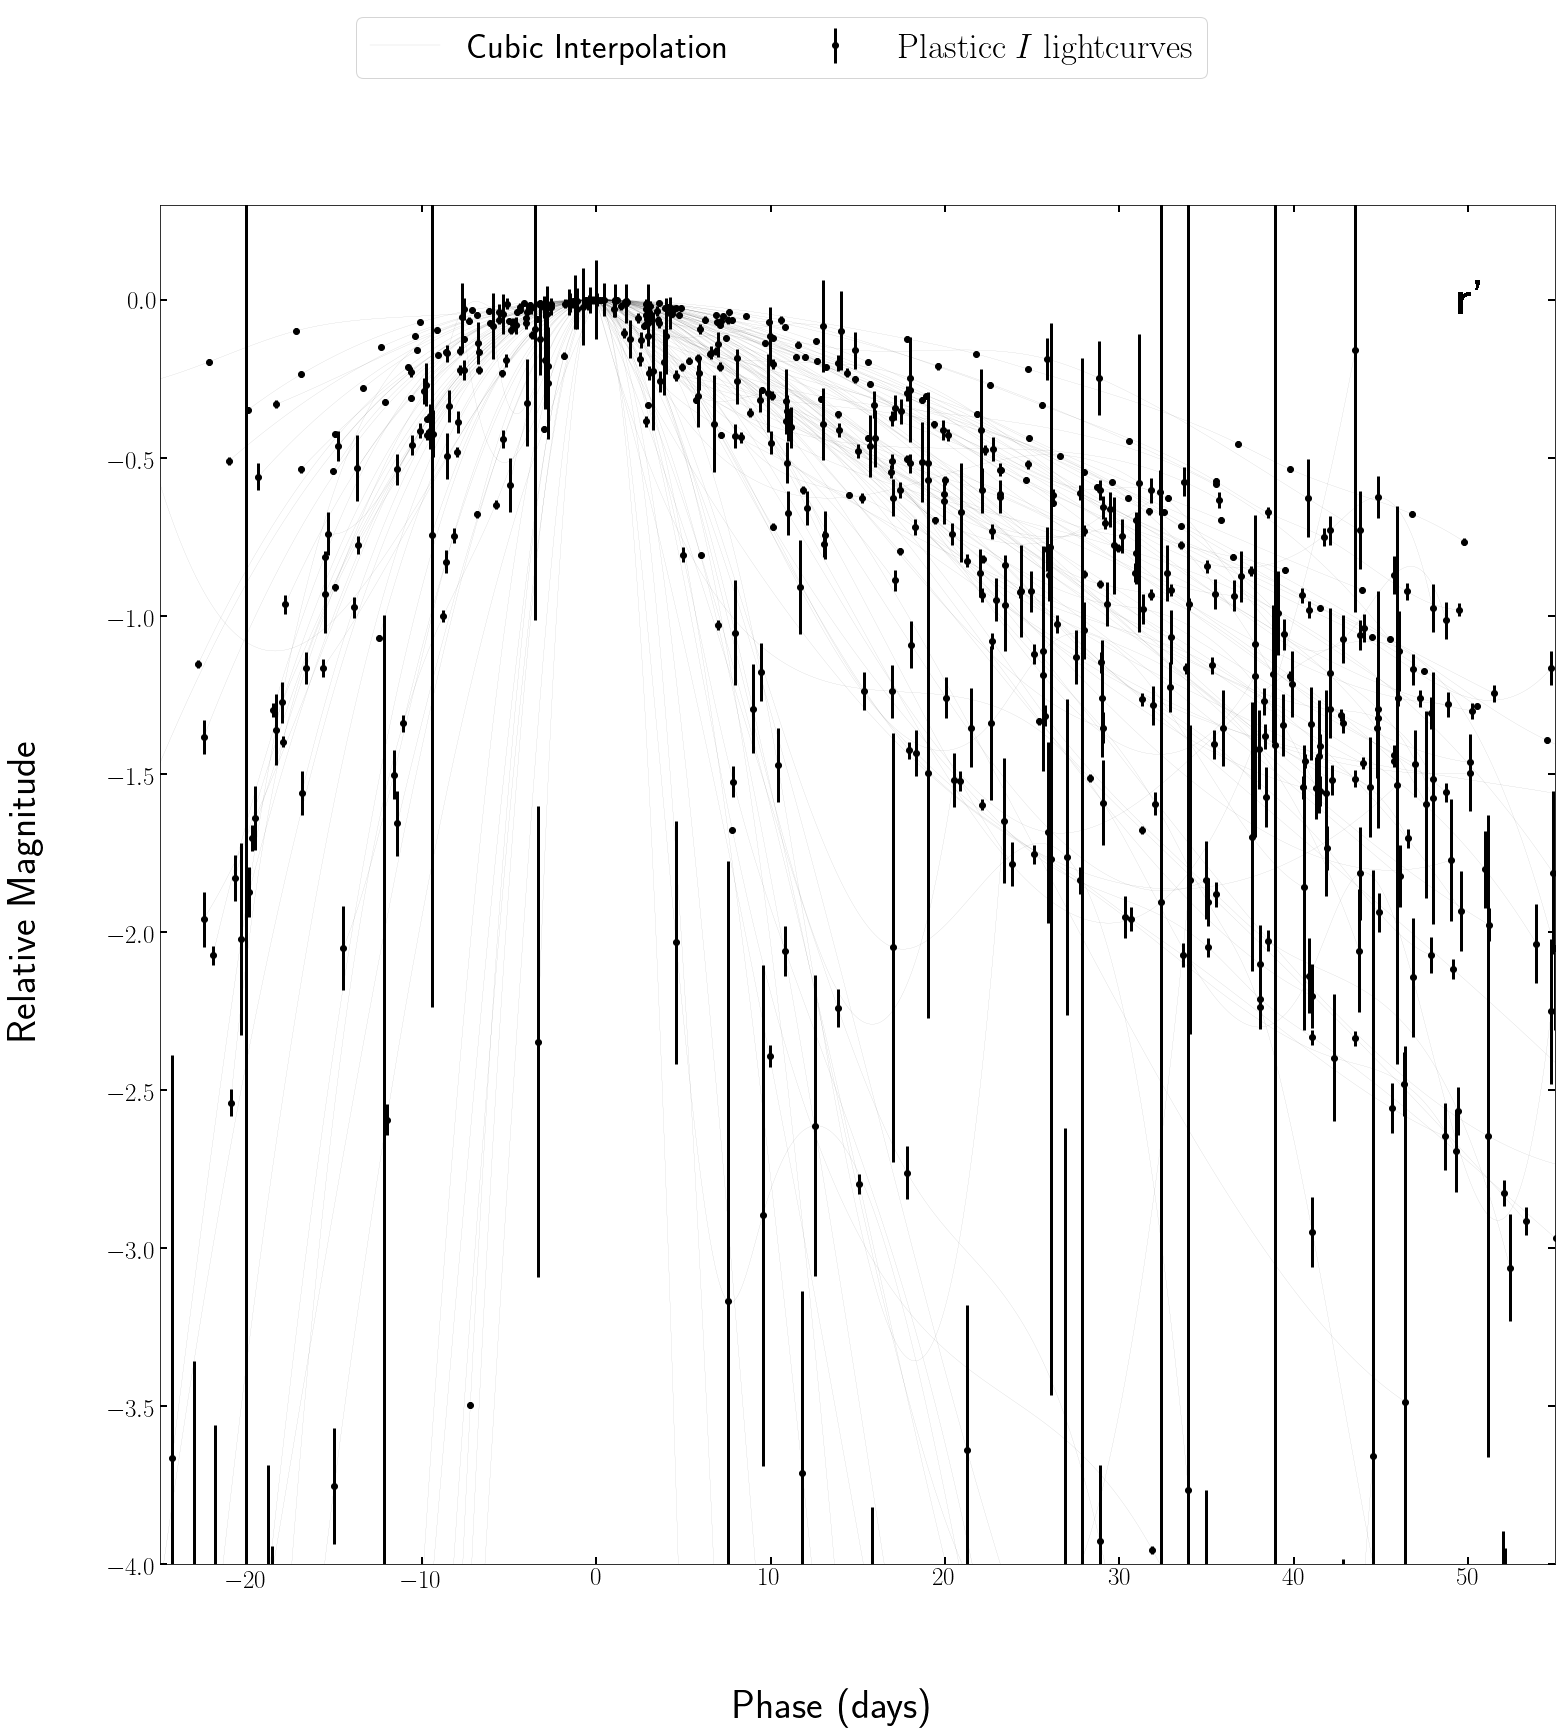

In [19]:
bb = 'r'

band_sntypes = [*tmpl[bb]]
    
fig = plt.figure(figsize=(25,25))
ax = fig.gca()

for i,ID in enumerate(high_SN):

    df_r = df1[(df1.object_id == ID) & (df1.passband == b)].reset_index(drop=True)
    df_new = df1[(df1.object_id == ID) & (df1.passband == b)].reset_index(drop=True)
    #     print(len(df_new))
    df_new = df_new[df_new.flux>0].reset_index(drop=True)
    df_r = df_r[df_r.flux>0].reset_index(drop=True)


    if len(df_new.flux)==0:
        print(ID)
        continue
        
    df_r['m'] = -2.5*np.log10(df_r.flux/(10**(-0.4*27.5)))
    median = np.nanmedian(df_r['m'])
    df_r['m'] = df_r['m']- median
    df_r['m_err'] = 2.5 / np.log(10) * df_r['flux_err'] / df_r['flux']

    df_new['m'] = -2.5*np.log10(df_new.flux/(10**(-0.4*27.5)))
    median = np.nanmedian(df_new['m'])
    df_new['m'] = df_new['m']- median
    df_new['m_err'] = 2.5 / np.log(10) * df_new['flux_err'] / df_new['flux']



    x = df_new.mjd.values
    y = df_new['m'].values
    yerr = df_new['m_err'].values

    #     x = x - x[np.argmin(y)]
    x_peak = df_r.mjd[np.argmin(df_r.m)]
    y_peak = df_r.m[np.argmin(df_r.m)]
    
    
    if ID == 218492:
        low_lim = -20
        up_lim = 55
    else:
        low_lim = -25
        up_lim = 55

    ind = (x < up_lim + x_peak) & (x > low_lim + x_peak)
    y = y[ind]
    yerr = yerr[ind]
    x = x[ind]
    y =  y - y[np.argmin(y)]
    t = np.linspace(x.min(), x.max(), 1000)

    if len(y)<4:
        continue

    interpld_xmin = t[np.argmin(interp1d(x, y, kind='cubic')(t))]
    interpld_ymin = min(interp1d(x, y, kind='cubic')(t))



    globals()["max_"+str(bb)][0].append(t[np.argmin(interp1d(x, y, kind='cubic')(t))])
    globals()["max_"+str(bb)][1].append(min(interp1d(x, y, kind='cubic')(t)))


    x = df_new.mjd.values
    y = df_new['m'].values
    yerr = df_new['m_err'].values
    ind = (x < up_lim + x_peak) & (x > low_lim + x_peak)
    y = y[ind]
    yerr = yerr[ind]
    x = x[ind]
    y =  y - y[np.argmin(y)]


#     np.diff(np.abs(x - interpld_xmin)


    if i == 0:

        ax.errorbar(x - interpld_xmin,\
            -y + interpld_ymin, yerr=yerr, fmt='o',\
            linewidth = 3, color = 'k', label = r'$\mathrm{Plasticc }\; \rom{1} \; \mathrm{ light curves}$')
        ax.plot(t - interpld_xmin,\
            -interp1d(x, y, kind='cubic')(t) + interpld_ymin,\
            '-', linewidth = 0.1, color = 'k', alpha = 0.5, label = 'Cubic Interpolation')


    else:
        ax.errorbar(x - interpld_xmin,\
            -y + interpld_ymin, yerr=yerr, fmt='o',\
            linewidth = 3, color = 'k')
        ax.plot(t - interpld_xmin,\
            -interp1d(x, y, kind='cubic')(t) + interpld_ymin,\
            '-', linewidth = 0.1, color = 'k', alpha = 0.5)
        
        
        
    ax.tick_params(axis="both", direction="in", which="major",\
                                              right=True, top=True, size=7, labelsize=25, width = 2)
    
    ax.text(0.93, 0.92, bb+"'", transform=ax.transAxes,\
                               weight='bold', size = 50, color = 'k')
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, prop={'size':35})
# np.concatenate(ax)[0].set_yticklabels(['','-7', '-6','-5', '-4', '-3','-2', '-1', '0'], size=30)
# np.concatenate(ax)[2].set_yticklabels(['','-7', '-6', '-5', '-4', '-3','-2', '-1', '0'], size=30)

# np.concatenate(ax)[2].set_xticklabels(['', '-20', '-10','0', '10', '20','30', '40', '50', ''], size=30)
# np.concatenate(ax)[3].set_xticklabels(['', '-20','-10','0', '10', '20', '30', '40', '50', ''], size=30)


ax.set_xlim(-25,55)
ax.set_ylim(-4,0.3)

fig.text(0.5, 0.04, 'Phase (days)', ha='center', size = 40)
fig.text(0.04, 0.5, 'Relative Magnitude', va='center', rotation='vertical', size = 40)



In [ ]:
for i, hour in enumerate(phs):
    # i need at least 1 datapoint within 3 hours of the target hour (to take median)
    indx = (data['x'] >= hour) * (data['x'] < hour + window)
    #print (i, hour + window/2., indx.sum())

    #remove if less than 3 datapoints within 4 hours

    if indx.sum() < 3:
        continue


    #weighted average weighted by errorbars within hour and hour+window

    weights = 1.0 / ((data['yerr'][indx])**2)

    wmu[i] = np.average(data['y'][indx], axis = 0,
                        weights=weights)
    std[i] = np.std(data['y'][indx]) 

    wstd[i] = np.average((data['y'][indx]-wmu[i])**2,  axis = 0,
                         weights=weights)
    #median
    #med[i] = np.median(data['y'][indx])


    pc25[i], med[i], pc75[i] = np.nanpercentile(data['y'][indx], [25, 50, 75])

    # if hour < -20:
        # print ('phase: ' ,hour, ', median: ', med[i])


    indx_high = (data['y'][indx]<med[i])
    indx_low = (data['y'][indx]>med[i])

    err_ratio[i] = np.mean((data['yerr'][indx][indx_low])**2)/np.mean((data['yerr'][indx][indx_high])**2)
    weights_mean[i] = np.mean(1./(data['yerr'][indx])**2)
    weights_med[i] = np.median(1./(data['yerr'][indx])**2)